<a href="https://colab.research.google.com/github/Felipeferreira21/projeto-cana-acucar/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import os

In [ ]:
import os
import cv2
import numpy as np

def load_dataset(path_dataset, target_size=(125, 125)):
    dataset = []
    labels = []

    # Iterate over all folders in dataset_path
    for label in os.listdir(path_dataset):
        class_path = os.path.join(path_dataset, label)

        # check if the directory exists
        if os.path.isdir(class_path):
            # Initialize a counter for images in each class
            images_counter = 0

            # Iterate over all images in folder/class
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                # Load image with OpenCV
                image = cv2.imread(image_path)

                # Check if the image was loaded successfully
                if image is not None:
                    # Resize the image
                    image = cv2.resize(image, target_size)

                    # Add image and label to dataset
                    dataset.append(image)
                    labels.append(label)


                else:
                    print(f"Error loading image: {image_path}")

    return np.array(dataset), np.array(labels)

dataset_path = "drive/MyDrive/archive"
dataset, labels = load_dataset(dataset_path)

In [ ]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_counts.keys(), class_counts.values(), color='skyblue', width=0.6)

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Image Distribution by Class')

plt.show()

In [ ]:
import random
import matplotlib.pyplot as plt

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))

    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels == class_name)[0]
        sample_index = random.choice(indices_class)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels into numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(dataset, encoded_labels, test_size=0.2, random_state=42)


def preprocess_image(image):
    resized_image = cv2.resize(image, (125, 125))

    #Normalize values between 0 and 1
    normalized_image = resized_image / 255.0
    return normalized_image

# Apply preprocessing to training and testing sets
X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])

# Check the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

In [ ]:
!pip install efficientnet

In [ ]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


num_classes = len(np.unique(labels))

model = models.Sequential()

efficientnet_model = EfficientNetB0(input_shape=(125, 125, 3), include_top=False, weights='imagenet', pooling='max')

model.add(efficientnet_model)

model.add(Dense(128, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(64, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(32, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(units=num_classes, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

custom_optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stopping])

In [ ]:
from tensorflow.keras.models import load_model, save_model

## model.save('drive/MyDrive/modelosML')

In [ ]:
modelo_carregado = load_model('drive/MyDrive/modelosML')

In [ ]:
# plt.plot(modelo_carregado.history['loss'], label='Training Loss')
# plt.plot(modelo_carregado.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# Plot training and validation loss
# plt.plot(history.history['accuracy'], label='Training accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation accuracy')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = modelo_carregado.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = y_test

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('real')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

1/1 [==============================] - 0s 52ms/step


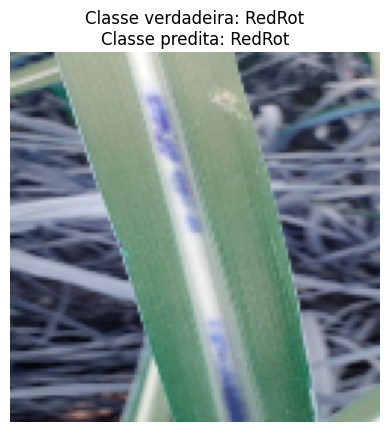

In [ ]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Selecionar uma imagem de teste aleatória do conjunto de teste
indice_imagem_aleatoria = random.randint(0, len(X_test) - 1)
imagem_aleatoria = X_test[indice_imagem_aleatoria]
classe_verdadeira = y_test[indice_imagem_aleatoria]

# Fazer a previsão usando o modelo carregado na imagem aleatória
previsao = modelo_carregado.predict(np.expand_dims(imagem_aleatoria, axis=0))
classe_predita = np.argmax(previsao)

# Mapear os rótulos das classes de volta para as strings originais usando o LabelEncoder
classe_verdadeira = label_encoder.inverse_transform([classe_verdadeira])[0]
classe_predita = label_encoder.inverse_transform([classe_predita])[0]

# Plotar a imagem
plt.imshow(imagem_aleatoria)
plt.title(f'Classe verdadeira: {classe_verdadeira}\nClasse predita: {classe_predita}')
plt.axis('off')
plt.show()
